## Bytes Saving - Counting Formulation

### 1. Average number of ‘useful comparisons’ per category:
```math
u_{\%} = \frac{1}{|C|} \sum_{C} \left( \frac{\sum_{} (i \geq t)}{\sum_{} i} \right) \times 100
```

Where:
- C refers to a category
- t is the threshold for similarity
- $\sum_{} (i)$ is the total number of comparisons in a category
- $\sum_{} (i >= t)$ is the total number of 'useful comparisons' in a particular category
- $\frac{1}{|C|} \sum_{C}$ computes the average over all categories

### 2. Average number of comparisons per category:
```math
N = \frac{1}{|C|} \sum_{C} {\sum_{} (i)}
````

### 3. Average number of ‘useful comparisons’:
```math
\text{Avg\_useful\_comparisons} = u_{\%} \times N
````

### 4. Number of images in the client’s cache for a category:
```math
X_C \quad \text{or} \quad \bar X = \sum_{C} X_C
````

Where $X_C$ is the number of cached images in category \(C\) and $ \bar X \subseteq N $

### 5. Bytes saved:
```math
\text{Bytes\_saved} = (2 \times 10^6)p - 8X
````

Where:
- $p$ is the probability of serving an image from the cache.
- Each image is assumed to be 2 MB.
- The $8 \times X$ term corresponds to 64-bit hashes for $X$ images.

### 6. Probability $p$:
```math
p = 1 - \frac{\binom{N(1-u)}{X}}{\binom{N}{X}}
````

In [1]:
import pandas as pd
import os
from math import comb
import matplotlib.pyplot as plt

In [2]:
path = 'true_labels'
dfs = []

for website in os.listdir(path):
    website_path = os.path.join(path, website)
    
    if os.path.isdir(website_path): 
        for filename in os.listdir(website_path):
            if filename.endswith('.csv'):
                file_path = os.path.join(website_path, filename)
                df = pd.read_csv(file_path, index_col=0)
                dfs.append(df)

In [3]:
dfs[0].head()

,image_1_1,image_2_1,image_3_1,image_4_1,image_5_1,image_6_1,image_7_1,image_8_1,image_9_1,image_10_1
image_1_1,4,0,0,0,0,0,0,0,0,0
image_2_1,0,4,0,0,0,0,0,4,0,0
image_3_1,0,0,4,3,1,0,0,0,0,0
image_4_1,0,0,3,4,2,0,0,0,0,0
image_5_1,0,0,1,2,4,0,0,0,0,0


In [4]:
def extract_comparisons(df, threshold=1):
    num_useful_comparisons = 0
    total_comparisons = 0

    columns = df.columns
    for i in range(len(columns)):
        for j in range(i+1, len(columns)):
            # Ignore comparisons from the same article (i.e. same prefix img_1_*)
            if columns[i].split('_')[1] != columns[j].split('_')[1]:
                value = df.iloc[i, j]
                total_comparisons += 1
                if value >= threshold:
                    num_useful_comparisons += 1

    return num_useful_comparisons, total_comparisons

In [5]:
u_list = []
N_list = []

for df in dfs:
    num_useful_comparisons, total_comparisons = extract_comparisons(df)
    u_list.append(num_useful_comparisons)
    N_list.append(total_comparisons)

In [6]:
C = len(u_list)
u = (sum([u_list[i]/N_list[i] for i in range(C)]) / C)
print(f'u: {u*100:.2f} %')

u: 14.21 %


In [7]:
N = int(sum(N_list) / C)
print(f'N: {N}')

N: 210


In [9]:
X_vals = [1,5,10,15,20,30]
p_list = []
bytes_saved_list = []

image_size_bytes = 0.9 * 10**6 
hash_size_bytes = 8  

for X in X_vals:
    p = 1 - (comb(int(N * (1 - u)), X) / comb(N, X))
    p_list.append(p)

    bytes_saved = (image_size_bytes * p) - (hash_size_bytes * X)
    bytes_saved_list.append(bytes_saved)

for i, X in enumerate(X_vals):
    print(f"X: {X}, p: {p_list[i]:.4f}, Bytes Saved: {bytes_saved_list[i]:.2f} bytes")

X: 1, p: 0.1429, Bytes Saved: 128563.43 bytes
X: 5, p: 0.5411, Bytes Saved: 486905.36 bytes
X: 10, p: 0.7937, Bytes Saved: 714251.61 bytes
X: 15, p: 0.9093, Bytes Saved: 818233.63 bytes
X: 20, p: 0.9610, Bytes Saved: 864759.57 bytes
X: 30, p: 0.9933, Bytes Saved: 893752.28 bytes


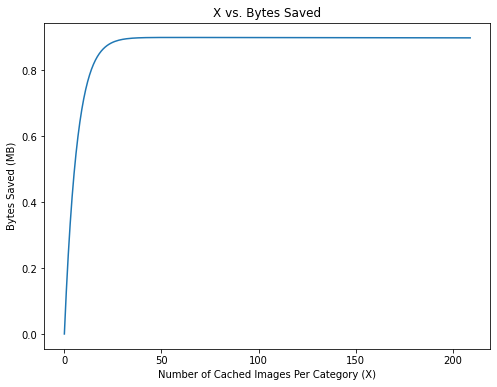

In [11]:
X_values = list(range(0, N)) 

p_values = []
bytes_saved_values = []

for X in X_values:
    p = 1 - (comb(int(N * (1 - u)), X) / comb(N, X))
    p_values.append(p)
    bytes_saved = (image_size_bytes * p) - (hash_size_bytes * X)
    bytes_saved_values.append(bytes_saved)

bytes_saved_values_mb = [value / 10**6 for value in bytes_saved_values]

plt.figure(figsize=(8, 6))
plt.plot(X_values, bytes_saved_values_mb)
plt.title('X vs. Bytes Saved')
plt.xlabel('Number of Cached Images Per Category (X)')
plt.ylabel('Bytes Saved (MB)')
plt.show()